In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [51]:
def load_and_merge_datasets(directory, file_range):
    data_list = []
    for i in file_range:
        file_path = f"{directory}/{i}.csv"
        try:
            data = pd.read_csv(file_path, delimiter=';')
            data_list.append(data)
        except FileNotFoundError:
            print(f"File {file_path} not found.")
    return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()

In [52]:
def make_stationary(data, column):
    log_series = np.log(data[column] + 1)
    stationary_series = log_series.diff().dropna()
    return stationary_series

In [53]:
def plot_real_vs_predicted(data, stationary_data, model_name, y_true, y_pred, feature):
    if y_true is not None:
        anomaly_indices = np.where(y_true == 1)[0]
        if len(anomaly_indices) > 0:
            # Берем участок вокруг первой найденной аномалии
            start_idx = max(anomaly_indices[0] - 50, 0)
            end_idx = min(anomaly_indices[0] + 50, len(y_true))

            plt.figure(figsize=(15, 6))

            # График реальных аномалий
            plt.plot(data['datetime'].iloc[start_idx:end_idx], stationary_data[feature].iloc[start_idx:end_idx],
                     label=f'{feature} (Stationary)', color='blue')
            plt.scatter(
                data['datetime'].iloc[start_idx:end_idx][y_true[start_idx:end_idx] == 1],
                stationary_data[feature].iloc[start_idx:end_idx][y_true[start_idx:end_idx] == 1],
                color='orange', edgecolors='darkorange', linewidths=1.5, s=100,
                label='True Anomalies'
            )

            # График предсказанных аномалий
            plt.scatter(
                data['datetime'].iloc[start_idx:end_idx][y_pred[start_idx:end_idx] == 1],
                stationary_data[feature].iloc[start_idx:end_idx][y_pred[start_idx:end_idx] == 1],
                facecolors='none', edgecolors='red', linewidths=1.5, s=100,
                label='Predicted Anomalies'
            )

            plt.title(f'{model_name}: {feature} (Real vs Predicted Anomalies)')
            plt.xlabel('Datetime')
            plt.ylabel(feature)
            plt.legend()
            plt.grid()
            plt.show()

### Здесь стоит сделать дисклеймер, что скорее всего столь низкая точность определения аномалий связана с тем, что я обучал на объединённых данных. Возможно стоило взять каждое измерение отдельно, но для меня объеденить было более очевидным. Плюс ко всему можно поиграть с GridSearch и подобрать лучшие гиперпараметры, но как правило точность не получает прибавку за 20%, так что моя точность будет маленькой в любом случае

Valve1: Local Outlier Factor (LOF)
--------------------------------------------------
Optimized Precision: 0.37
Optimized Recall: 0.11
Optimized F1: 0.17



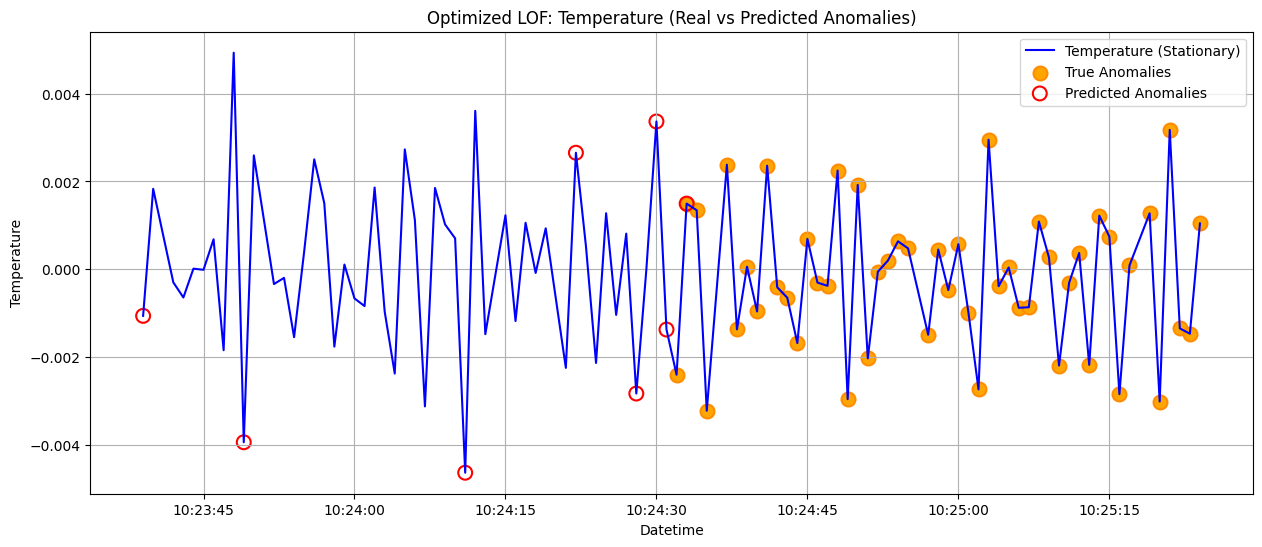

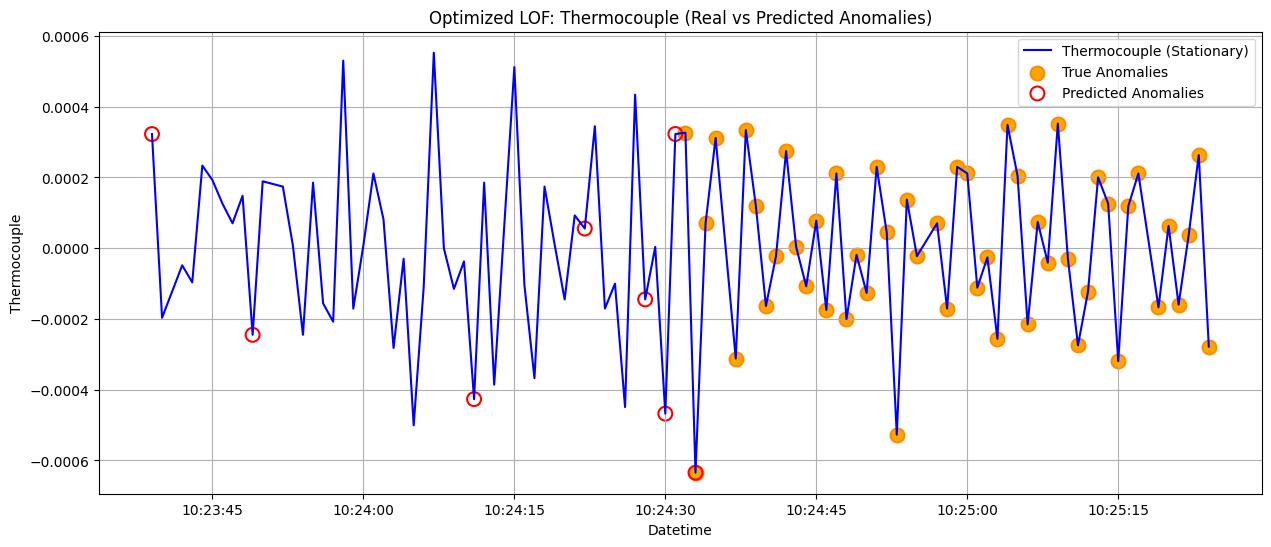

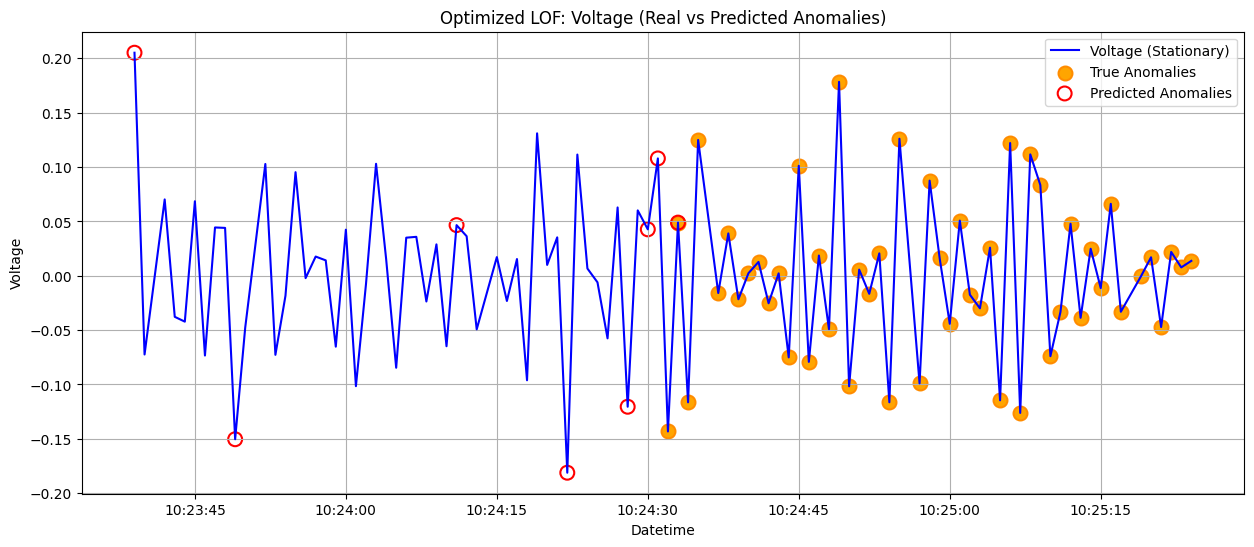

In [61]:
print("Valve1: Local Outlier Factor (LOF)\n" + "-"*50)
data_valve1 = load_and_merge_datasets('data/valve1', range(16))
if 'datetime' in data_valve1.columns:
    data_valve1['datetime'] = pd.to_datetime(data_valve1['datetime'])
    data_valve1 = data_valve1.sort_values('datetime')

features = ['Temperature', 'Thermocouple', 'Voltage']
if all(col in data_valve1.columns for col in features):
    stationary_features = {feature: make_stationary(data_valve1, feature) for feature in features}
    stationary_data_valve1 = pd.DataFrame(stationary_features).dropna()
    scaler = StandardScaler()
    X_scaled_valve1 = scaler.fit_transform(stationary_data_valve1)

    y_true_valve1 = data_valve1['anomaly'].iloc[1:].values if 'anomaly' in data_valve1.columns else None

    lof_optimized = LocalOutlierFactor(
        n_neighbors=10,
        metric='euclidean',
        contamination=0.1
    )
    y_pred_lof_valve1 = lof_optimized.fit_predict(X_scaled_valve1)
    y_pred_lof_valve1 = np.where(y_pred_lof_valve1 == -1, 1, 0)

    if y_true_valve1 is not None:
        print(f"Optimized Precision: {precision_score(y_true_valve1, y_pred_lof_valve1):.2f}")
        print(f"Optimized Recall: {recall_score(y_true_valve1, y_pred_lof_valve1):.2f}")
        print(f"Optimized F1: {f1_score(y_true_valve1, y_pred_lof_valve1):.2f}\n")

    for feature in features:
        plot_real_vs_predicted(data_valve1, stationary_data_valve1, "Optimized LOF", y_true_valve1, y_pred_lof_valve1, feature)

Valve2: One-Class SVM
--------------------------------------------------
Precision: 0.45
Recall: 0.06
F1: 0.11



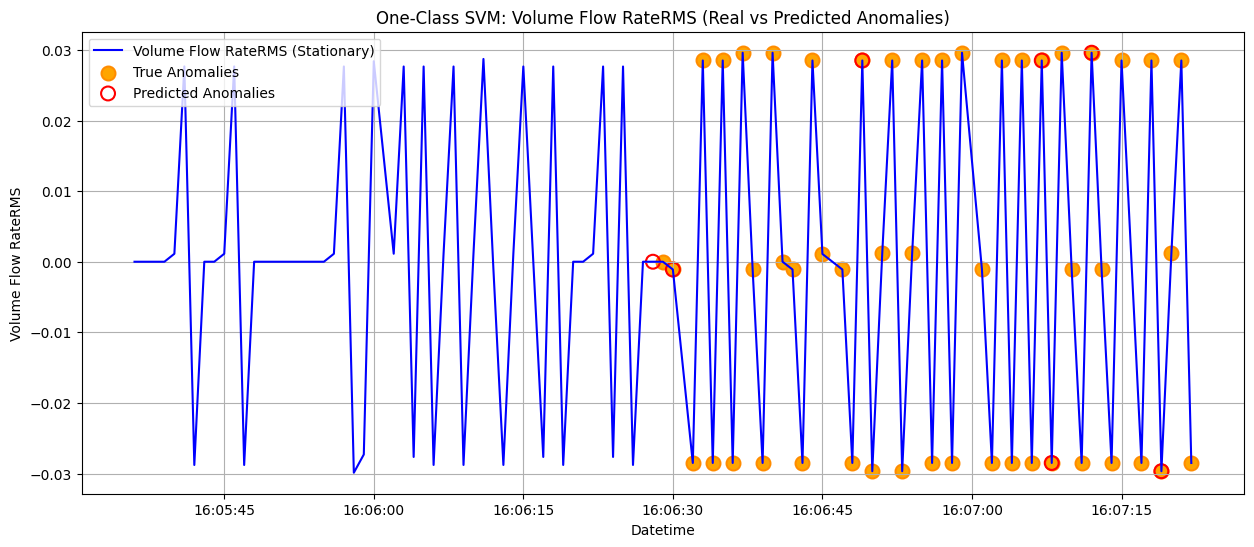

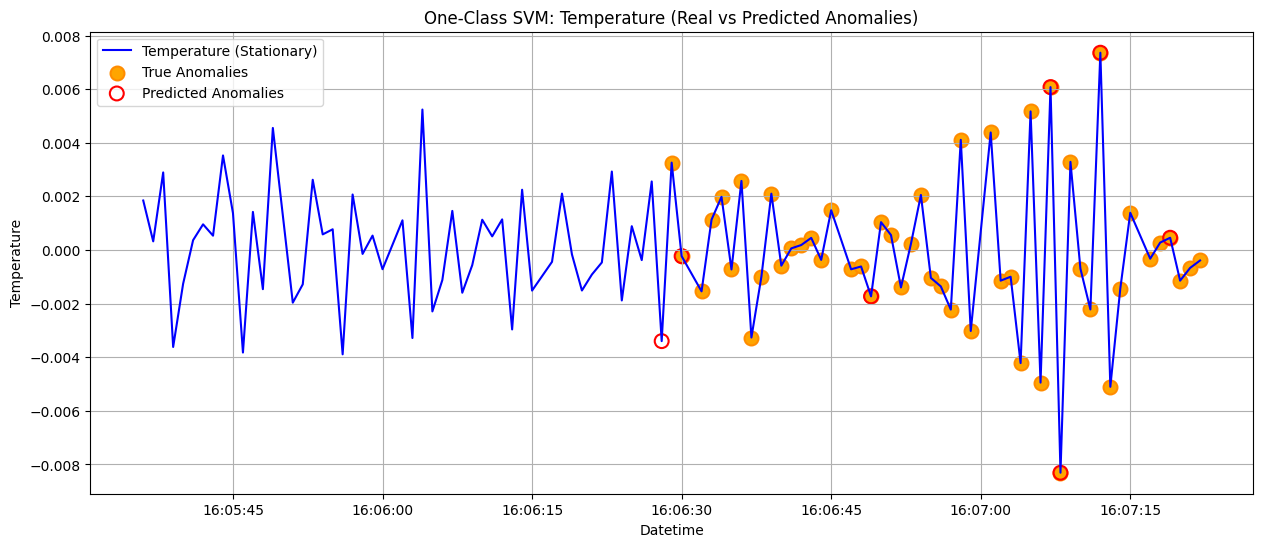

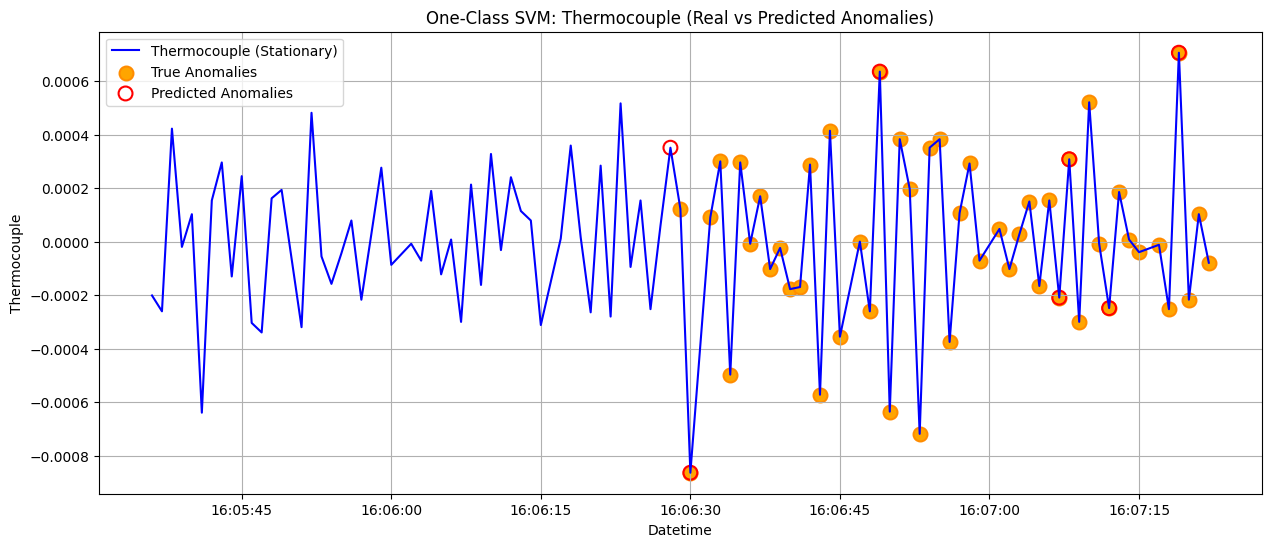

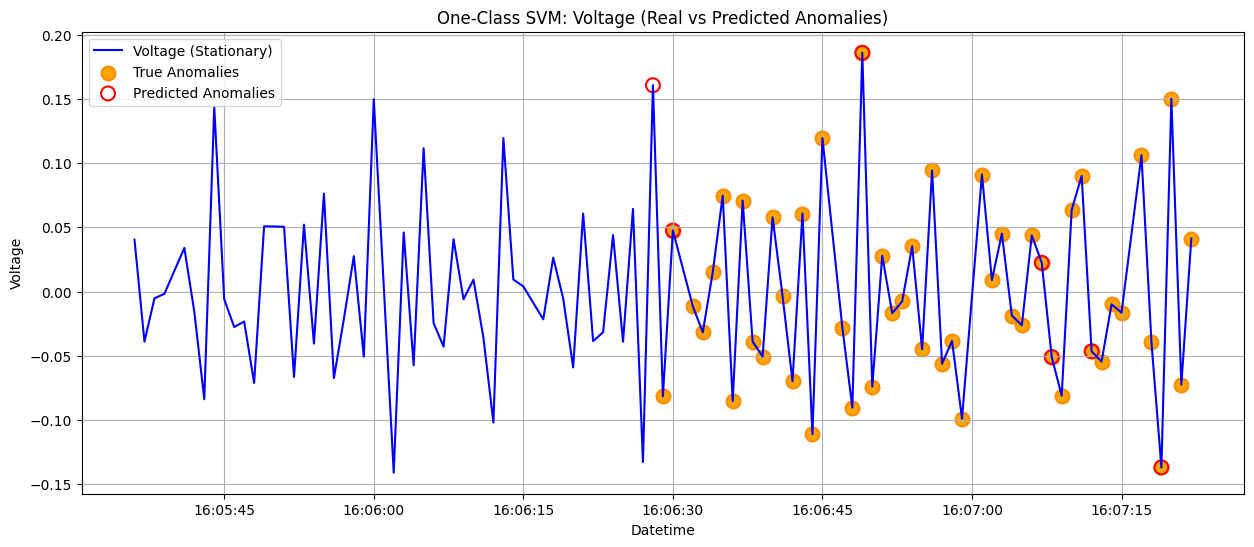

In [55]:
print("Valve2: One-Class SVM\n" + "-"*50)
data_valve2 = load_and_merge_datasets('data/valve2', range(4))
if 'datetime' in data_valve2.columns:
    data_valve2['datetime'] = pd.to_datetime(data_valve2['datetime'])
    data_valve2 = data_valve2.sort_values('datetime')

if all(col in data_valve2.columns for col in features):
    stationary_features = {feature: make_stationary(data_valve2, feature) for feature in features}
    stationary_data_valve2 = pd.DataFrame(stationary_features).dropna()
    scaler = StandardScaler()
    X_scaled_valve2 = scaler.fit_transform(stationary_data_valve2)

    y_true_valve2 = data_valve2['anomaly'].iloc[1:].values if 'anomaly' in data_valve2.columns else None
    oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
    oc_svm.fit(X_scaled_valve2)
    y_pred_svm_valve2 = oc_svm.predict(X_scaled_valve2)
    y_pred_svm_valve2 = np.where(y_pred_svm_valve2 == -1, 1, 0)

    if y_true_valve2 is not None:
        print(f"Precision: {precision_score(y_true_valve2, y_pred_svm_valve2):.2f}")
        print(f"Recall: {recall_score(y_true_valve2, y_pred_svm_valve2):.2f}")
        print(f"F1: {f1_score(y_true_valve2, y_pred_svm_valve2):.2f}\n")

    for feature in features:
        plot_real_vs_predicted(data_valve2, stationary_data_valve2, "One-Class SVM", y_true_valve2, y_pred_svm_valve2, feature)

Other: Isolation Forest
--------------------------------------------------
Precision: 0.51
Recall: 0.07
F1: 0.13



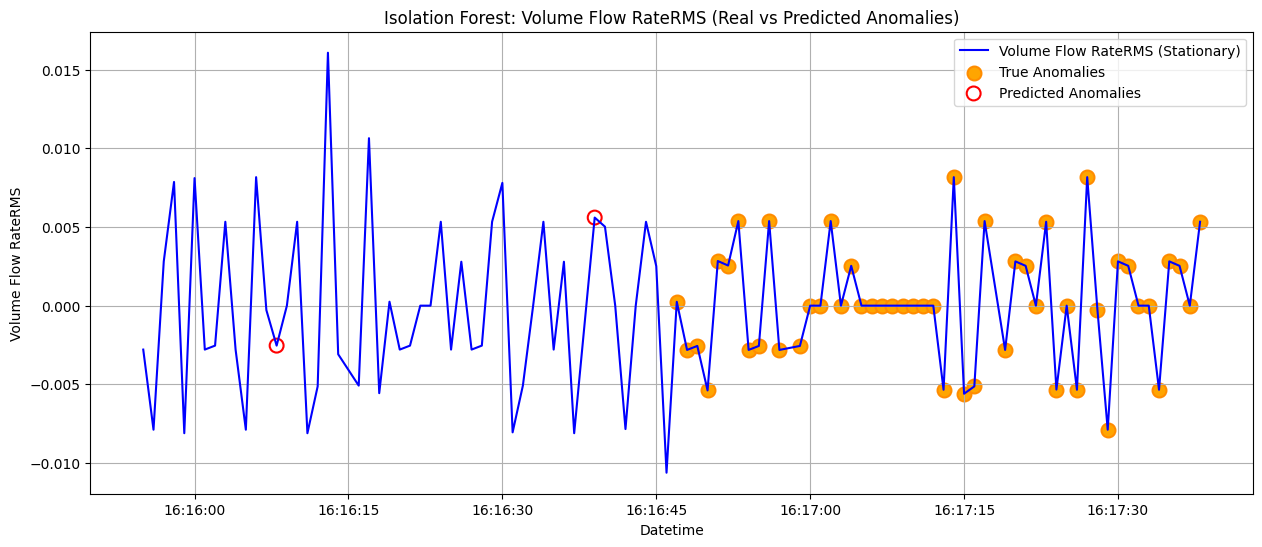

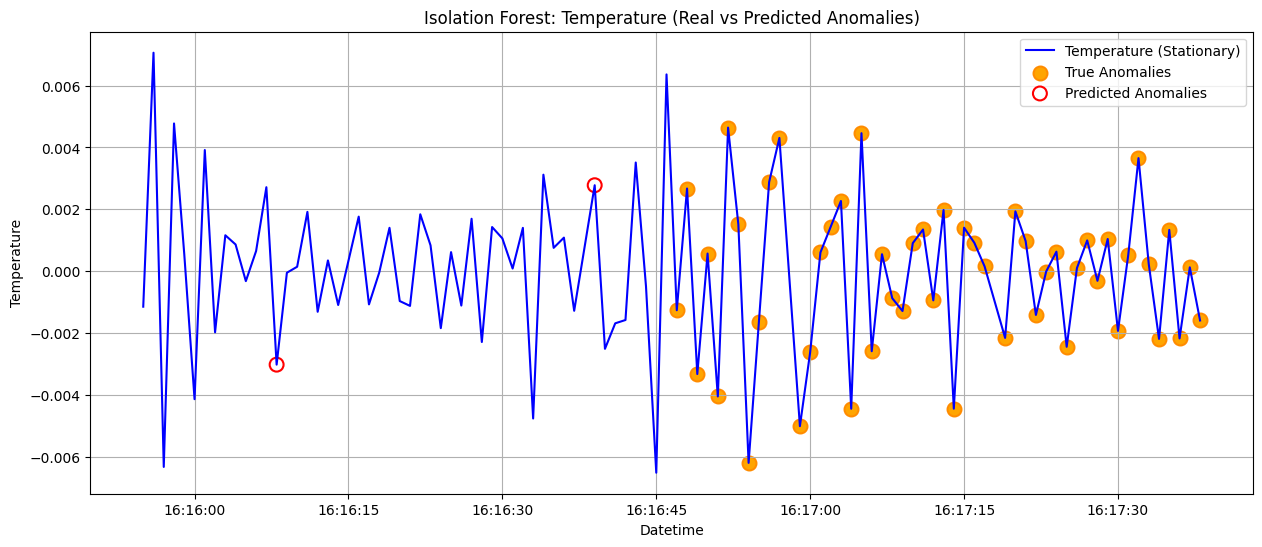

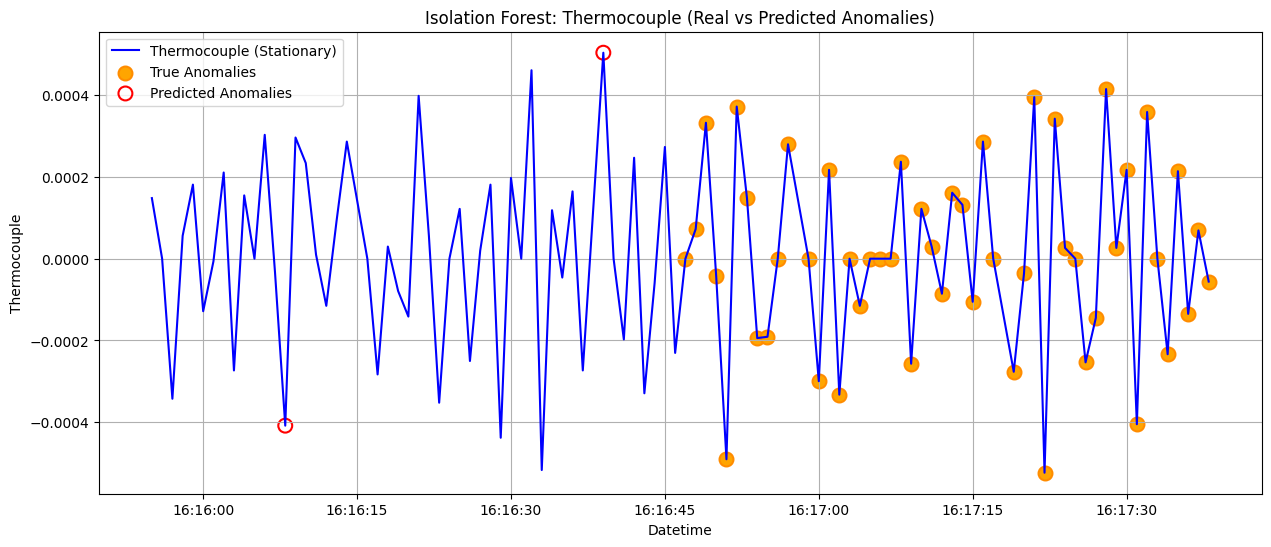

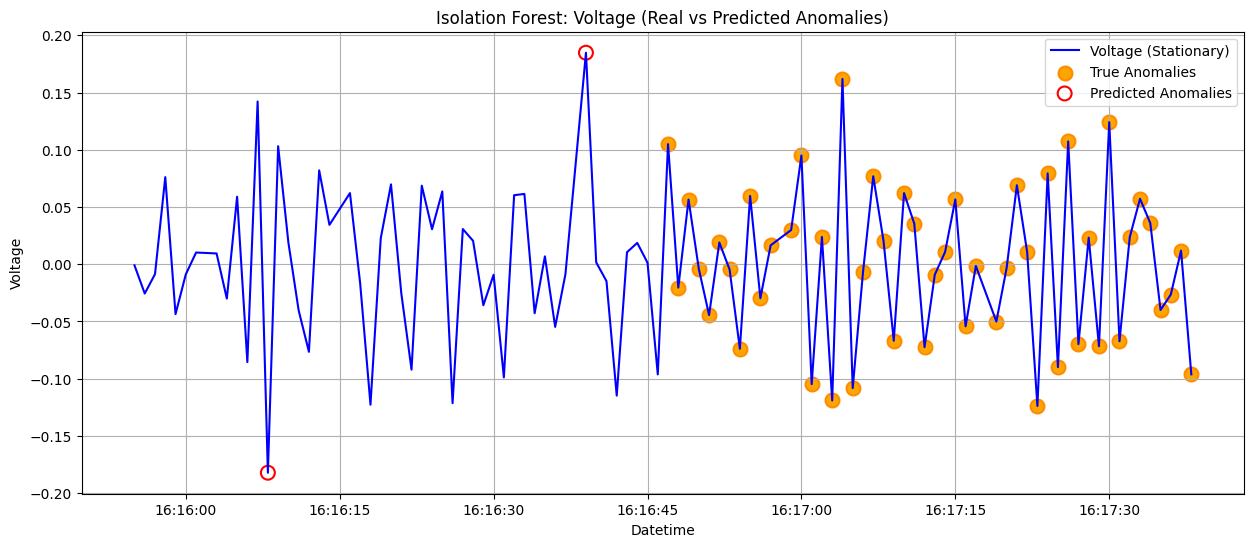

In [56]:
print("Other: Isolation Forest\n" + "-"*50)
data_other = load_and_merge_datasets('data/other', range(1, 15))
if 'datetime' in data_other.columns:
    data_other['datetime'] = pd.to_datetime(data_other['datetime'])
    data_other = data_other.sort_values('datetime')

if all(col in data_other.columns for col in features):
    stationary_features = {feature: make_stationary(data_other, feature) for feature in features}
    stationary_data_other = pd.DataFrame(stationary_features).dropna()
    scaler = StandardScaler()
    X_scaled_other = scaler.fit_transform(stationary_data_other)

    y_true_other = data_other['anomaly'].iloc[1:].values if 'anomaly' in data_other.columns else None
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(X_scaled_other)
    y_pred_iso_other = iso_forest.predict(X_scaled_other)
    y_pred_iso_other = np.where(y_pred_iso_other == -1, 1, 0)

    if y_true_other is not None:
        print(f"Precision: {precision_score(y_true_other, y_pred_iso_other):.2f}")
        print(f"Recall: {recall_score(y_true_other, y_pred_iso_other):.2f}")
        print(f"F1: {f1_score(y_true_other, y_pred_iso_other):.2f}\n")

    for feature in features:
        plot_real_vs_predicted(data_other, stationary_data_other, "Isolation Forest", y_true_other, y_pred_iso_other, feature)